In [1]:
from torchvision import models, transforms
from torch.autograd import Variable
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np

In [2]:
import json
idx2label = []
cls2label = {}
cls2idx = {}
with open("../../data/imagenet_class_index.json", "r") as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}    
#print(idx2label)
#print(cls2label)
# cls2idx

In [3]:
model = models.inception_v3(pretrained=True)

In [4]:
def get_image(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')       

In [5]:
def img2tensor(image):
    transf = get_input_transform()
    image = transf(image)
    return Variable(image.unsqueeze(0), requires_grad=False)

def class2tensor(target_class):
    return torch.LongTensor([target_class])

def get_input():
    #raw_input = get_image('D:/datasets/ImageNet/train/n02410509/n02410509_123.JPEG') #'bison'
    raw_input = get_image('D:/GitHubSrc/tensorwatch/data/dogs.png')
    input = img2tensor(raw_input)
    target_class = class2tensor(240)  #cat.jpg --> 14, dog --> 240, 239
    return raw_input, input, target_class 

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    


def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

#transf = get_input_transform() 
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [6]:
cls2label['n02410509']
cls2idx['n02410509']

347

In [7]:
raw_input, input, target_class = get_input()

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [8]:
model.eval() # without this you will have wrong predictions for resnet
model.cpu()
logits = model(input)
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
[(p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy())]
#probs.detach()[0].numpy()

[(0.9916045, 239, 'Bernese_mountain_dog'),
 (0.005068442, 241, 'EntleBucher'),
 (0.0027020762, 240, 'Appenzeller'),
 (0.0006195897, 238, 'Greater_Swiss_Mountain_dog'),
 (2.1539222e-06, 214, 'Gordon_setter')]

In [9]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [10]:
# raw_images = [raw_input, raw_input]
# raw_images_sized = [pill_transf(i) for i in raw_images]

In [11]:
a = batch_predict([pill_transf(raw_input)])
a.squeeze().argmax()

239

In [12]:
from lime import lime_image

In [17]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(raw_input)), batch_predict, top_labels=5, hide_color=0, num_samples=1000)

In [14]:
from skimage.segmentation import mark_boundaries

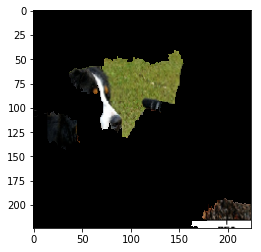

In [22]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=True)
img = mark_boundaries(temp/255.0, mask)
plt.imshow(temp/255.0)

In [16]:
explanation.top_labels[1]

241